### Download Data

The data is taken from http://archive.ics.uci.edu/ml/machine-learning-databases/00240/, but you can have it in the form of the UCI-HAR-Dataset.zip.

Extract it to the folder of your notebook with the solution (or suitably adjust the paths to training and test data specified below (TRAIN, TEST).  

Spcifically, the split into training and testing data is already done. The dataset contains 7352 training and 2947 test samples.  

Each sample consists of nine timeseries of float values, each of length 128.

The nine timeseries are collected by an accelerometer and a gyroscope that contain information about the motion and the orientation, respectively.

In [49]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### Load Data

In [50]:
# Useful Constants
TRAIN = "UCI_HAR_Dataset/train/"
TEST = "UCI_HAR_Dataset/test/"

# x-values, 'signals'
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]
X_train_signals_paths = [TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths =  [TEST  + "Inertial Signals/" + signal + "test.txt"  for signal in INPUT_SIGNAL_TYPES]


# y-values, 'labels'
#Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]
N_CLASSES = len(LABELS)
y_train_path = TRAIN + "y_train.txt"
y_test_path  = TEST  + "y_test.txt"

In [51]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
print(X_train.shape, X_test.shape)

(7352, 128, 9) (2947, 128, 9)


In [52]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

def one_hot(y, n_classes):
    y = y.reshape(len(y))
    return np.eye(n_classes)[np.array(y, dtype=np.int32)]

def label_from_onehot(vectors):
    indices = []
    for vector in vectors:
        indices.append(np.argmax(vector))
    return np.array(indices)

Y_train = one_hot(load_y(y_train_path), N_CLASSES)
Y_test = one_hot(load_y(y_test_path), N_CLASSES)
print(Y_train.shape, Y_test.shape)

(7352, 6) (2947, 6)


#### Plot some samples

In [53]:
X_train_per_class = {}
for c in range(N_CLASSES):
    mask = label_from_onehot(Y_train)==c
    X_train_per_class[c] = X_train[mask]

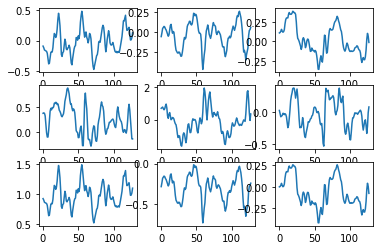

In [54]:
def plot_lines(X, nsamples):
    t = range(128)
    for i in range(9):
        plt.subplot(3,3,i+1)
        for j in range(np.minimum(X.shape[0],nsamples)):
            plt.plot(t,X[j,:,i])
    plt.show()
    
plot_lines(X_train_per_class[1], 1)

In [55]:
# Input Data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
means = np.mean(X_train, axis=(0,1))
stdevs = np.std(X_train, axis=(0,1))

print("X shape, Y_shape:")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print()
print("Mean / Stdev for each feature:")
for i in range(9):
    print("%7.4f | %7.4f"%(means[i], stdevs[i]))

X shape, Y_shape:
(7352, 128, 9) (7352, 6)
(2947, 128, 9) (2947, 6)

Mean / Stdev for each feature:
-0.0006 |  0.1948
-0.0003 |  0.1224
-0.0003 |  0.1069
 0.0005 |  0.4068
-0.0008 |  0.3819
 0.0001 |  0.2557
 0.8047 |  0.4141
 0.0288 |  0.3910
 0.0865 |  0.3578


### Normalization

Can be skipped since the features are all at similar scales aready.

### Utilities

In [56]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [57]:
import sklearn
from sklearn import metrics
import pandas as pd
activities = ["walk", "up", "down", "sit", "stand", "lay"]

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.argmax(scores, axis=1)
    labels = np.argmax(Y_test, axis=1)
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({activities[i] : cm[:,i] for i in range(len(activities))}, activities)
    return df

## Specify and Train Models

Try different architectures to solve the activity recognition problem.

At minimum implement
* Model with a single layer of SimpleRNN
* Model with several layers of SimpleRNNs
* Model with several CNN layers
* Mixed model with several layers of CNNs, then its output model with 1+ layers of SimpleRNNs

Try with different number of units.

Report about your findings.

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam

from sklearn import metrics

### Single Layer SimpleRNN

In [59]:
print(N_CLASSES, LABELS)

6 ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']


In [60]:
### START YOUR CODE

n_hidden = 32
n_values = 128
n_timeseries = 9
n_classes = N_CLASSES
clipnorm = 0.2


model = Sequential()
model.add(SimpleRNN(units = n_hidden,
                    input_shape = (n_values, n_timeseries)
                   ))
model.add(Dense(n_classes, 
                activation='softmax'
               ))
### END YOUR CODE

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_17 (SimpleRNN)    (None, 32)                1344      
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 198       
Total params: 1,542
Trainable params: 1,542
Non-trainable params: 0
_________________________________________________________________


In [61]:
opt = Adam(clipnorm=clipnorm)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [62]:
### START YOUR CODE
batch_size = 128
n_epochs   = 50

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/50
58/58 [==============================] - 3s 30ms/step - loss: 1.5634 - accuracy: 0.3576 - val_loss: 1.2695 - val_accuracy: 0.5141
Epoch 2/50
58/58 [==============================] - 1s 26ms/step - loss: 1.1837 - accuracy: 0.5502 - val_loss: 1.1993 - val_accuracy: 0.5456
Epoch 3/50
58/58 [==============================] - 1s 25ms/step - loss: 1.0050 - accuracy: 0.6373 - val_loss: 1.0562 - val_accuracy: 0.5904
Epoch 4/50
58/58 [==============================] - 1s 25ms/step - loss: 0.8987 - accuracy: 0.6668 - val_loss: 0.9366 - val_accuracy: 0.6322
Epoch 5/50
58/58 [==============================] - 1s 26ms/step - loss: 0.7867 - accuracy: 0.7031 - val_loss: 0.8695 - val_accuracy: 0.6610
Epoch 6/50
58/58 [==============================] - 1s 25ms/step - loss: 0.7568 - accuracy: 0.7048 - val_loss: 0.8640 - val_accuracy: 0.6498
Epoch 7/50
58/58 [==============================] - 1s 24ms/step - loss: 0.6593 - accuracy: 0.7455 - val_loss: 0.7823 - val_accuracy: 0.6909
Epoch 8/50
58

Train accuracy (end): 0.9300870299339294
Train accuracy (max): 0.9355277419090271
Test accuracy (end) : 0.8252460360527039
Test accuracy (max) : 0.8564642071723938


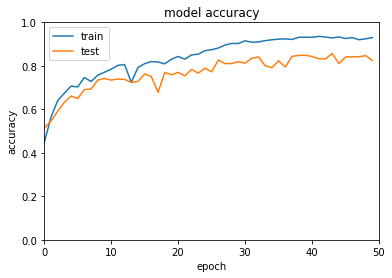

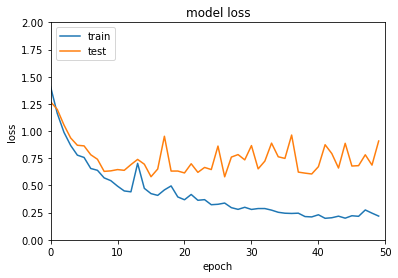

,walk,up,down,sit,stand,lay
walk,427,10,59,0,0,0
up,51,367,47,5,1,0
down,12,19,389,0,0,0
sit,5,18,0,342,120,6
stand,18,75,0,42,397,0
lay,0,27,0,0,0,510


In [63]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

...

Gradient clipping help smoothing the training and eliminates extreme gradient changes, in our case it also increase the performance slightly.

### Stacked Simple RNNs

In [64]:
### START YOUR CODE

n_hidden = 32
n_values = 128
n_timeseries = 9
n_classes = N_CLASSES
clipnorm = 0.2

model_stacked = Sequential()
model_stacked.add(SimpleRNN(units = n_hidden,
                            input_shape = (n_values, n_timeseries),
                            return_sequences=True
                           ))
model_stacked.add(SimpleRNN(units = n_hidden,
                            return_sequences=True
                           ))
model_stacked.add(SimpleRNN(units = n_hidden,
                            return_sequences=False
                           ))
model_stacked.add(Dense(n_classes,
                        activation='softmax'
                       ))

opt = Adam(clipnorm=clipnorm)
model_stacked.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
### END YOUR CODE

model_stacked.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_18 (SimpleRNN)    (None, 128, 32)           1344      
_________________________________________________________________
simple_rnn_19 (SimpleRNN)    (None, 128, 32)           2080      
_________________________________________________________________
simple_rnn_20 (SimpleRNN)    (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 198       
Total params: 5,702
Trainable params: 5,702
Non-trainable params: 0
_________________________________________________________________


In [65]:
### START YOUR CODE
batch_size = 128
n_epochs   = 50

log = model_stacked.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/50
58/58 [==============================] - 8s 97ms/step - loss: 1.4613 - accuracy: 0.4622 - val_loss: 1.0553 - val_accuracy: 0.6040
Epoch 2/50
58/58 [==============================] - 5s 85ms/step - loss: 0.7924 - accuracy: 0.6902 - val_loss: 0.9409 - val_accuracy: 0.6434
Epoch 3/50
58/58 [==============================] - 5s 84ms/step - loss: 0.6273 - accuracy: 0.7358 - val_loss: 0.8212 - val_accuracy: 0.6722
Epoch 4/50
58/58 [==============================] - 5s 86ms/step - loss: 0.6115 - accuracy: 0.7492 - val_loss: 0.7752 - val_accuracy: 0.7085
Epoch 5/50
58/58 [==============================] - 5s 90ms/step - loss: 0.5080 - accuracy: 0.8003 - val_loss: 0.7549 - val_accuracy: 0.7228
Epoch 6/50
58/58 [==============================] - 6s 101ms/step - loss: 0.4366 - accuracy: 0.8251 - val_loss: 0.6431 - val_accuracy: 0.7903
Epoch 7/50
58/58 [==============================] - 5s 93ms/step - loss: 0.4446 - accuracy: 0.8343 - val_loss: 0.6679 - val_accuracy: 0.7815
Epoch 8/50
5

Train accuracy (end): 0.9518498182296753
Train accuracy (max): 0.9530739784240723
Test accuracy (end) : 0.870037317276001
Test accuracy (max) : 0.8985409140586853


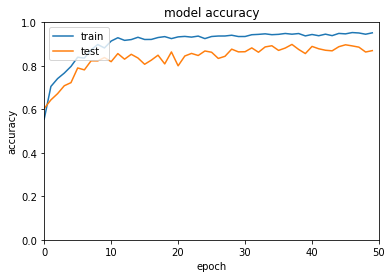

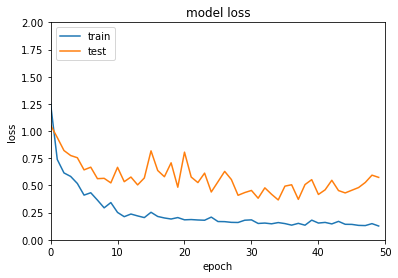

,walk,up,down,sit,stand,lay
walk,466,1,28,0,1,0
up,72,373,26,0,0,0
down,2,5,413,0,0,0
sit,1,19,4,399,68,0
stand,7,18,0,104,403,0
lay,0,0,0,0,27,510


In [66]:
performance_plots(model_stacked, X_test, Y_test, log, n_epochs)
confusion_matrix(model_stacked, X_test, Y_test)

#### Findings

...

Train and test accuracy are as expected, slightly improved.

### Several CNN Layers

In [67]:
### START YOUR CODE
from tensorflow.keras.layers import InputLayer, Conv1D, Dropout, Flatten

n_hidden = 32
n_values = 128
n_timeseries = 9
n_classes = N_CLASSES
clipnorm = 0.2
dropout_rate = 0.5

model_cnn = Sequential()
model_cnn.add(InputLayer(input_shape=(n_values, n_timeseries)))
model_cnn.add(Conv1D(filters=16,
                     kernel_size=5,
                     strides=2,
                     activation='relu'))
model_cnn.add(Dropout(dropout_rate))
model_cnn.add(Conv1D(filters=32,
                     kernel_size=3,
                     strides=2,
                     activation='relu'))
model_cnn.add(Dropout(dropout_rate))
model_cnn.add(Conv1D(filters=64,
                     kernel_size=3,
                     strides=2,
                     activation='relu'))
model_cnn.add(Dropout(dropout_rate))
model_cnn.add(Conv1D(filters=64,
                     kernel_size=3,
                     strides=2,
                     activation='relu'))

model_cnn.add(Flatten())
model_cnn.add(Dense(n_classes, activation='softmax'))

opt = Adam(clipnorm=clipnorm)
model_cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
### END YOUR CODE

model_cnn.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 62, 16)            736       
_________________________________________________________________
dropout_10 (Dropout)         (None, 62, 16)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 30, 32)            1568      
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 14, 64)            6208      
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 64)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 6, 64)           

In [68]:
### START YOUR CODE
batch_size = 128
n_epochs   = 50

log = model_cnn.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/50
58/58 [==============================] - 3s 23ms/step - loss: 1.6992 - accuracy: 0.2434 - val_loss: 1.4513 - val_accuracy: 0.4954
Epoch 2/50
58/58 [==============================] - 1s 14ms/step - loss: 1.1669 - accuracy: 0.5611 - val_loss: 0.8462 - val_accuracy: 0.6071
Epoch 3/50
58/58 [==============================] - 1s 15ms/step - loss: 0.7226 - accuracy: 0.6644 - val_loss: 0.7640 - val_accuracy: 0.6284
Epoch 4/50
58/58 [==============================] - 1s 16ms/step - loss: 0.6176 - accuracy: 0.7134 - val_loss: 0.6959 - val_accuracy: 0.7258
Epoch 5/50
58/58 [==============================] - 1s 14ms/step - loss: 0.5277 - accuracy: 0.7558 - val_loss: 0.6458 - val_accuracy: 0.7581
Epoch 6/50
58/58 [==============================] - 1s 15ms/step - loss: 0.4400 - accuracy: 0.8203 - val_loss: 0.6805 - val_accuracy: 0.7720
Epoch 7/50
58/58 [==============================] - 1s 18ms/step - loss: 0.3705 - accuracy: 0.8510 - val_loss: 0.6214 - val_accuracy: 0.7866
Epoch 8/50
58

Train accuracy (end): 0.9542981386184692
Train accuracy (max): 0.9542981386184692
Test accuracy (end) : 0.9144893288612366
Test accuracy (max) : 0.9216151833534241


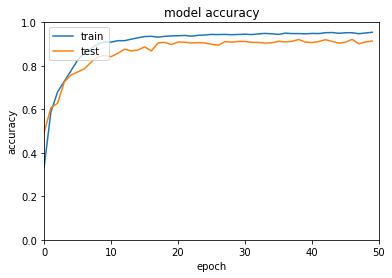

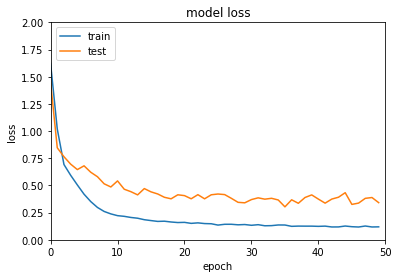

,walk,up,down,sit,stand,lay
walk,478,14,4,0,0,0
up,0,454,17,0,0,0
down,0,23,397,0,0,0
sit,0,19,0,391,76,5
stand,0,0,0,68,464,0
lay,0,26,0,0,0,511


In [69]:
performance_plots(model_cnn, X_test, Y_test, log, n_epochs)
confusion_matrix(model_cnn, X_test, Y_test)

#### Findings

...

CNN perform much better than both our RNN models.

### Mixed CNN and RNN

In [ ]:
### START YOUR CODE

model = Sequential(...)
...

### END YOUR CODE

model.summary()

In [ ]:
### START YOUR CODE
batch_size = ...
n_epochs   = ...

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

In [ ]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

...